# Max - Cut

In this nb, I present an algorithm to solve max-cut on any weighted graph instance by applying the quantum approximate optimization algorithm (QAOA) [1] parametrized by angles that can be optimized over via Bayesian Optimization. The implementation below is based off of the description in a recent paper by the Rigetti Group [2], who run simulations, and an experiment on a 19 qubit processor with particular connectivity.

As for an algorithmic description, the key idea is that we can hybridize classical and quantum resources by constructing a low-depth quantum algorithm used as a subroutine in a larger classical computation. A short description of the circuit construction can be found in [2], and the BayesianOptimization package [3] was used for the optimization. Simulation testing was done by generating random graphs of fixed number of nodes, and the ExactEigensolver method in qiskit.aqua was used to obtain the correct value.

[1] E. Farhi, J. Goldstone, S. Gutmann e-print arXiv 1411.4028 (2014)

[2] Rigetti Computing, 'Unsupervised Machine Learning on a Hybrid Quantum Computer' (2017)

[3] https://github.com/fmfn/BayesianOptimization

In [542]:
# qiskit and bayesian optimization
import numpy as np
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit import IBMQ
from qiskit import BasicAer, execute
from math import pi
import random
from bayes_opt import BayesianOptimization
import time

In [482]:
# plotting
import matplotlib.pyplot as plt
import matplotlib.axes as axes
%matplotlib inline
import numpy as np
import networkx as nx

In [483]:
# max-cut IBM package
from qiskit.aqua import Operator, run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.aqua.translators.ising import max_cut, tsp
from qiskit.aqua.algorithms import VQE, ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua import QuantumInstance

# setup aqua logging
import logging
from qiskit.aqua import set_qiskit_aqua_logging


## Cut Value Computation

Classical computation of max-cut from a partition bitstring.

In [484]:
def cut_value(adjacency_matrix, edge_weights, partition):
    """
    input: adjacency_matrix, list of lists of boolean values corresponding to existence of edge
           edge_weights, list of lists of values
           partition, bitstring mapping nodes to 0-1 partition
    output: float, cut value corresponding to partition
    """
    
    #initialization
    N = len(adjacency_matrix)
    cut = 0.0
    
    #cut value
    for i in range(N):
        for j in range(N):
            if i!=j and adjacency_matrix[i][j] == 1 and partition[i] != partition[j] and partition[i] == '0':
                cut += edge_weights[i][j]
                
    return cut

## Exact Solution by Brute Force

In [644]:
def concatenate(partition_list):
    """
    function takes list of bools partition_list, returns bitstring of 0-1
    """
    outputstring = ''
    for boolean in partition_list:
        outputstring +=str(boolean)
    return outputstring

In [663]:
def brute_max_cut(adjacency_matrix, edge_weights):
    """ brute force enumeration, returns float of optimal cut"""
    
    n = len(adjacency_matrix)
    best_cost_brute = 0
    
    for b in range(2**n):
        x = [int(t) for t in reversed(list(bin(b)[2:].zfill(n)))]
        cost = cut_value(adjacency_matrix, edge_weights, concatenate(x))
        if best_cost_brute < cost:
            best_cost_brute = cost
            xbest_brute = x 
            
    return best_cost_brute

## Exact Solution using ExactEigensolver

Doesn't work for directed graphs!!!!

In [485]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
def exact_max_cut(edge_weights):
    qubitOp, offset = max_cut.get_max_cut_qubitops(edge_weights)
    ee = ExactEigensolver(qubitOp, k=1)
    result = ee.run()
    x = max_cut.sample_most_likely(result['eigvecs'][0])
    #print('solution:', max_cut.get_graph_solution(x))
    return max_cut.max_cut_value(x, edge_weights)

## Single Unit QAOA Circuit

Here I develop a single unit of the QAOA circuit. The unit requires its own angles $\gamma$ and $\beta$, as well as the global adjacency matrix and edge weights.

### Driver Circuit

In [486]:
def driver_circuit(qregister, beta):
    """
    input: qregister QuantumRegister object, arbitrary # of qubits
            beta, specific rotation angle in radians in [0, pi]
    output: QuantumCircuit object, driver
    """
    driver = QuantumCircuit(qregister)
    driver.rx(beta, qregister)
    return driver

In [487]:
q = QuantumRegister(3)

In [488]:
driver_circuit(q, pi/2).draw()

### Cost Circuit

In [489]:
def cost_circuit(qregister, gamma, adjacency_matrix, edge_weights):
    """
    input: - qregister QuantumRegister object, arbitrary # of qubits
           - gamma, specific rotation angle in radians [0, 2pi]
           - adjacency_matrix, list of lists where ij = 1 if qubits are connected by directed edge
           - edge_weights, list of lists of values
           
    output: QuantumCircuit object, cost unitary
    """
    
    # initialize circuit, and qubit count
    N = len(adjacency_matrix)
    cost = QuantumCircuit(qregister)
    cost.h(qregister)
    
    # construct unit cost circuit, from commutivity
    for i in range(N):
        for j in range(i+1, N):
            if adjacency_matrix[i][j] == 1:
                
                # basic cost unit
                cost.cx(qregister[i], qregister[j])
                cost.rz(gamma * edge_weights[i][j], qregister[j])
                cost.cx(qregister[i], qregister[j])
                
    return cost

In [490]:
q = QuantumRegister(3)

In [491]:
a = [[1, 1, 1], [1, 1, 1], [1, 1, 1]]
w = np.zeros((3, 3))
for i in range(len(w)):
    for j in range(i+1, len(w)):
        w[i][j] = random.random()
        w[j][i] = w[i][j]

In [492]:
cost_circuit(q, pi/4, a, w).draw()

### Single unit

In [493]:
def unit_circuit(qregister, adjacency_matrix, edge_weights, gamma, beta):
    return cost_circuit(qregister, gamma, adjacency_matrix, edge_weights) + driver_circuit(qregister, beta)

In [494]:
unit_circuit(q, a, w, pi/8, pi/4).draw();

## QAOA Circuit

In [495]:
def QAOA(adjacency_matrix, edge_weights, gamma_list, beta_list):
    """
    input: - adjacency_matrix, adjacency_matrix, list of lists where ij = 1 if qubits are connected by directed edge
           - edge_weights, list of lists of edge weights
           - gamma_list, list of cost angles
           - beta_list, list of beta angles
           
    output: QuantumCircuit object, result of appending multiple circuits for various different angles
            length of angles lists determines depth of circuit in unit_circuits
    """
    
    # initialize register and circuit
    N = len(adjacency_matrix) 
    qregister = QuantumRegister(N)
    cregister = ClassicalRegister(N)
    circuit = QuantumCircuit(qregister, cregister)
    
    # Quantum circuit construction
    for gamma, beta in zip(gamma_list, beta_list):
        circuit += unit_circuit(qregister, adjacency_matrix, edge_weights, gamma, beta)
       
    # partition
    circuit.measure(qregister, cregister)
        
    return circuit

In [496]:
QAOA(a, w, [pi/4], [pi/6]).draw();

## Calling the QC

### Physical Computer

In [497]:
IBMQ.load_accounts(hub=None)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqprovider.py:272: UserWarning: Credentials are already in use.
  warnings.warn('Credentials are already in use.')


In [498]:
print("Available backends:")
IBMQ.backends()

Available backends:


[<IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQBackend('ibmqx2') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>,
 <IBMQSimulator('ibmq_qasm_simulator') from IBMQ()>]

In [499]:
from qiskit.providers.ibmq import least_busy

large_enough_devices = IBMQ.backends(filters=lambda x: x.configuration().n_qubits < 10 and
                                                       not x.configuration().simulator)
backend = least_busy(large_enough_devices)
print("The best backend is " + backend.name())

The best backend is ibmqx2


### Simulation Backend

In [500]:
backend = BasicAer.get_backend('qasm_simulator')

## Bayesian Optimization

Here I use the Bayesian optimization package to optimize over the choice of gamma and beta. The depth, in the number of driving cycles p = 1, is assumed constant.

In [654]:
def optimize(adjacency_matrix, edge_weights, verbose = 2, Niterations = 10, initialpoints = 5, st = 100):
    """
    Inputs: - adjacency_matrix, list of lists 
            - edge_weights, list of lists of floats
            - verbose, = 2 prints everything, = 1 prints only when a maximum is observed, = 0 is silent
            - initialpoints, integer number of search points (see BayesianOptimization package)
            - Niterations, number of optimization iterations/updates
            
    Output: - BayesianOptimization object result of applying method on QAOA quantum circuit
    """
    
    #########################################################################
    def optimizing_function(gamma, beta):
        """
        Optimizing function on the rotation angles
        
        Input: - gamma in [0, 2pi]
               - beta in [0, pi]
               see circuit functions for description of gates
               
        Output: Cut value resulting from running quantum circuit
        """
    
        circuit = QAOA(adjacency_matrix, edge_weights, [gamma], [beta])
        job = execute(circuit, backend, shots = st)
        result = job.result()
        counts = result.get_counts(circuit)
    
        max_cut = 0
        maxp = None
        
        for partition in counts:
            current_cut = cut_value(adjacency_matrix, edge_weights, partition)
            if current_cut > max_cut or not maxp:
                maxp = partition
                max_cut = current_cut
                                                    
        return max_cut
    
    ############################################################################
    # Call optimization method on optimizing function
    
    pbounds = {'gamma': (0, 2*pi), 'beta': (0,  pi)}
        
    optimizer = BayesianOptimization(
        f=optimizing_function,
        pbounds=pbounds,
        verbose = verbose
    )

    #start = time.time()

    optimizer.maximize(
        init_points = initialpoints,
        n_iter = Niterations,
    )

    #end = time.time()
    #print('Bayesian Optimization Runtime was: ', end - start)
    
    return optimizer

### Test

In [457]:
# generate random directed graph
N = 10
adjacency_matrix = np.zeros((N, N))
edge_weights = np.zeros((N, N))
for i in range(N):
    for j in range(i+1, N):
        if random.random() < .7:
            adjacency_matrix[i][j] = 1
            adjacency_matrix[j][i] = 1
            edge_weights[i][j] = random.random()
            edge_weights[j][i] = edge_weights[i][j]

In [458]:
optimizer = optimize(adjacency_matrix, edge_weights)

|   iter    |  target   |   beta    |   gamma   |
-------------------------------------------------
|  1        |  9.97     |  0.7326   |  1.25     |
|  2        |  9.143    |  2.705    |  5.635    |
|  3        |  9.026    |  2.986    |  1.879    |
|  4        |  9.81     |  2.5      |  1.186    |
|  5        |  9.956    |  0.0      |  4.04     |
|  6        |  9.697    |  0.0      |  6.283    |
|  7        |  10.31    |  1.517    |  0.0      |
|  8        |  10.31    |  3.142    |  0.0      |
|  9        |  9.896    |  0.0      |  0.0      |
|  10       |  9.896    |  2.366    |  0.0      |
|  11       |  9.201    |  0.0      |  2.581    |
|  12       |  9.201    |  1.435    |  4.174    |
|  13       |  10.39    |  0.0      |  5.093    |


In [459]:
exact_max_cut(edge_weights)

10.391568560377422

In [460]:
targets = [res['target'] for res in optimizer.res]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


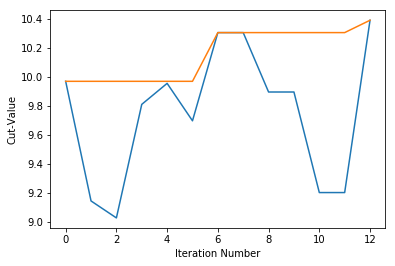

In [461]:
multiple_convergence_plots([targets,cumulative_objective(targets)])

## Testing Simulation

In [ ]:
def one_pass(N, p = 0.7, Niterations = 10, verbose = 2, shots = 100):
    """
    One run of the optimizer on random input graph, 
    returns cumulative list of objective values during optimization
    
    inputs: N, integer of number of nodes in graph
            p, float of probability of existence of edge
            verbose, = 2 prints everything, = 1 prints only when a maximum is observed, = 0 is silent
    
    
    """
    # generate random directed graph
    adjacency_matrix = np.zeros((N, N))
    edge_weights = np.zeros((N, N))
    allzero = True
    for i in range(N):
        for j in range(i+1, N):
            if random.random() < p:
                allzero = False
                adjacency_matrix[i][j] = 1
                adjacency_matrix[j][i] = 1
                edge_weights[i][j] = random.random()
                edge_weights[j][i] = edge_weights[i][j]
                
    if allzero:
        return None
                    
    # Normalize edge cost for max_cut
    exact_cut = brute_max_cut(edge_weights)
    for i in range(N):
        for j in range(N):
            edge_weights[i][j] = edge_weights[i][j]/exact_cut
    # run optimizer      
    optimizer = optimize(adjacency_matrix, edge_weights, verbose, Niterations, st = shots)
    
    return cumulative_objective([res['target'] for res in optimizer.res])

In [ ]:
convergence_plot(one_pass(5, Niterations = 5))

In [648]:
def multiple_pass(N, n_tests, n_iters=10, verbose = 0,  shots = 40):
    
    objective_listoflists = []
    avg = 0
    
    for i in range(n_tests):
        print("Starting "+ str(i+1) + "th test")
        results = one_pass(N, .7, n_iters, verbose, shots)
            
        if results:
            objective_listoflists.append(results)
            avg += objective_listoflists[-1][-1]/n_tests
        else:
            avg += 1/n_tests
                
    multiple_convergence_plots(objective_listoflists)
    print("The average accuracy was: ", avg)

Starting 1th test
Starting 2th test
Starting 3th test
Starting 4th test
Starting 5th test
Starting 6th test
Starting 7th test
Starting 8th test
Starting 9th test
Starting 10th test
The average accuracy was:  0.9870686306271736


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


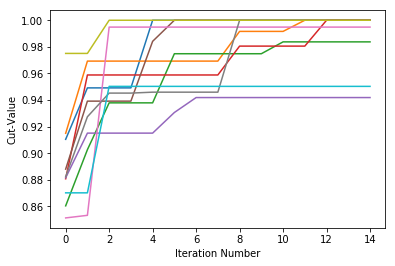

In [539]:
multiple_pass(10, 10)

## Statistics and Plot functions

In [394]:
def plot_convergence(objective_list):
    n_iter = len(objective_list)
    fig, ax = plt.subplots()
    ax.plot(range(n_iter), objective_list)
    ax.set(xlabel = "Iteration Number", ylabel = "Cut-Value")
    fig.show()

In [395]:
def multiple_convergence_plots(list_of_objectives):
    ncurves = len(list_of_objectives)
    n_iter = len(list_of_objectives[0])
    fig, ax = plt.subplots()
    for i in range(ncurves):
        ax.plot(range(n_iter), list_of_objectives[i])
    ax.set(xlabel = "Iteration Number", ylabel = "Cut-Value")
    fig.show()

In [396]:
def cumulative_objective(objective_list):
    #cumulative maximum
    result = [objective_list[0]]
    for i in range(1,len(objective_list)):
        if objective_list[i] > result[i-1]:
            result.append(objective_list[i])
        else:
            result.append(result[i-1])
    return result

## Quantum Computer Testing

In [665]:
def qcpass(adjacency_matrix, niters, shots, verbose):
    
    N = len(adjacency_matrix)
    
    # generate random weights
    edge_weights = np.zeros((N, N))
    for i in range(N):
        for j in range(N):
            if adjacency_matrix[i][j]==1 and i!= j:
                edge_weights[i, j] = random.random()   
                    
    
    # Normalize edge cost for max_cut
    exact_cut = brute_max_cut(adjacency_matrix, edge_weights)
    for i in range(N):
        for j in range(N):
            edge_weights[i][j] = edge_weights[i][j]/exact_cut
                
    # run optimizer      
    optimizer = optimize(ibm_matrix, edge_weights, verbose, niters, st=shots)
    
    return cumulative_objective([res['target'] for res in optimizer.res])

In [652]:
def qcmultiple_pass(adjacency_matrix, n_tests, n_iters=10, verbose = 0, shots = 40):
    
    objective_listoflists = []
    avg = 0
    
    for i in range(n_tests):
        print("Starting "+ str(i+1) + "th test")
        results = qcpass(adjacency_matrix, n_iters, shots, verbose)
            
        if results:
            objective_listoflists.append(results)
            avg += objective_listoflists[-1][-1]/n_tests
        else:
            avg += 1/n_tests
                
    multiple_convergence_plots(objective_listoflists)
    print("The average accuracy was: ", avg)

## The Quantum Computer

In [546]:
from qiskit import IBMQ
from qiskit.tools.jupyter import *

In [606]:
token = '85c803accc9dd892e60ff645952740918526cc56a605b9c880ff40cac7a731a7d5b25c1804dbf97fecf5252de8388cdbad5305a80cae9b5bdbb3f30a5609c2f2'
url = 'https://api-qcon.quantum-computing.ibm.com/api/Hubs/ibm-q/Groups/open/Projects/main'

IBMQ.delete_accounts()
IBMQ.save_account(token, url)
IBMQ.load_accounts()

In [608]:
backend = IBMQ.backends()[-1]

In [609]:
config = backend.configuration()

In [610]:
config.backend_name

'ibmq_16_melbourne'

In [611]:
config.n_qubits


14

## IBMQ Layout

The experiment is optimized over the particular layout of the processor.

In [612]:
config.coupling_map

[[1, 0],
 [1, 2],
 [2, 3],
 [4, 3],
 [4, 10],
 [5, 4],
 [5, 6],
 [5, 9],
 [6, 8],
 [7, 8],
 [9, 8],
 [9, 10],
 [11, 3],
 [11, 10],
 [11, 12],
 [12, 2],
 [13, 1],
 [13, 12]]

In [630]:
## processor adjacency matrix
ibm_matrix = np.zeros((config.n_qubits, config.n_qubits))
for i in range(len(config.coupling_map)):
    u,v = config.coupling_map[i]
    ibm_matrix[u, v] = 1

In [613]:
%qiskit_backend_monitor backend

### Test 1

In [640]:
edge_weights1 = np.zeros((14, 14))
for i in range(14):
    for j in range(i+1, 14):
        if ibm_matrix[i][j]==1:
            edge_weights1[i, j] = random.random()  

In [642]:
optimizer = optimize(ibm_matrix, edge_weights1, 2, 20, 3, 40)

|   iter    |  target   |   beta    |   gamma   |
-------------------------------------------------
JobStatus.INITIALIZING
00010000110111
|  1        |  2.245    |  2.734    |  2.411    |
JobStatus.INITIALIZING
10011000100010
|  2        |  2.166    |  1.566    |  3.263    |
JobStatus.INITIALIZING
11011000100100
|  3        |  2.153    |  0.9952   |  2.689    |
JobStatus.INITIALIZING
11010000101101
|  4        |  2.447    |  3.142    |  0.0      |
JobStatus.INITIALIZING
01010000101110
|  5        |  2.447    |  3.142    |  6.283    |
JobStatus.INITIALIZING
10010010101111
|  6        |  2.382    |  0.0      |  6.283    |
JobStatus.INITIALIZING
10010000110000
|  7        |  2.245    |  2.22e-16 |  0.0      |
JobStatus.INITIALIZING
00011010110010
|  8        |  2.193    |  2.186    |  6.283    |
JobStatus.INITIALIZING
10010000110111
|  9        |  2.245    |  3.142    |  4.709    |
JobStatus.INITIALIZING
00010010111000
|  10       |  2.378    |  0.0      |  4.551    |
JobStatus.INITIALIZI

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


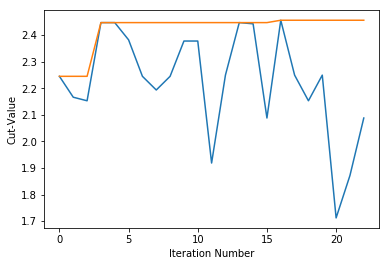

In [643]:
targets = [res['target'] for res in optimizer.res]
multiple_convergence_plots([targets,cumulative_objective(targets)])

### Test 2

In [626]:
qcpass(adjacency_matrix, 5, 20, 2)

|   iter    |  target   |   beta    |   gamma   |
-------------------------------------------------
JobStatus.INITIALIZING
10011000111101
|  1        |  2.59     |  3.117    |  4.034    |
JobStatus.INITIALIZING
11011010110101
|  2        |  2.623    |  0.9096   |  1.525    |
JobStatus.INITIALIZING
10111000101010
|  3        |  2.702    |  0.5836   |  2.291    |
JobStatus.INITIALIZING
01100100101011
|  4        |  2.744    |  1.502    |  1.247    |
JobStatus.INITIALIZING
00101000110010
|  5        |  2.961    |  0.5666   |  3.428    |
JobStatus.INITIALIZING
00100100101101
|  6        |  3.155    |  0.0      |  6.283    |
JobStatus.INITIALIZING
00100001011011
|  7        |  2.49     |  3.142    |  0.0      |
JobStatus.INITIALIZING
01010000101011
|  8        |  3.27     |  2.252    |  6.283    |
JobStatus.INITIALIZING
11010011101111
|  9        |  2.116    |  3.142    |  6.283    |
JobStatus.INITIALIZING
00110000101110
|  10       |  3.155    |  1.26     |  5.281    |


[2.5902169752952853,
 2.6234816489525414,
 2.7021897420159684,
 2.74446873005213,
 2.960513374241142,
 3.154506500973039,
 3.154506500973039,
 3.2702757618713942,
 3.2702757618713942,
 3.2702757618713942]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


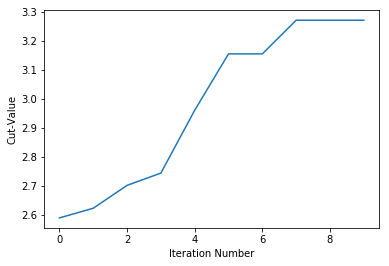

In [627]:
plot_convergence([2.5902169752952853,
 2.6234816489525414,
 2.7021897420159684,
 2.74446873005213,
 2.960513374241142,
 3.154506500973039,
 3.154506500973039,
 3.2702757618713942,
 3.2702757618713942,
 3.2702757618713942])

### Test 3

In [670]:
convergence3 = qcpass(ibm_matrix, 10, 40, 2)

|   iter    |  target   |   beta    |   gamma   |
-------------------------------------------------
|  1        |  0.7055   |  2.373    |  3.239    |
|  2        |  0.7392   |  1.987    |  0.3859   |
|  3        |  0.7747   |  0.7196   |  0.9606   |
|  4        |  0.7866   |  2.677    |  5.51     |
|  5        |  0.53     |  0.6735   |  2.017    |
|  6        |  0.7894   |  0.0      |  6.283    |
|  7        |  0.7747   |  0.0      |  0.0      |
|  8        |  0.9132   |  3.142    |  1.812    |
|  9        |  0.804    |  3.142    |  6.283    |
|  10       |  0.6123   |  1.532    |  6.283    |
|  11       |  0.5866   |  3.142    |  4.039    |
|  12       |  0.7477   |  0.0      |  4.671    |
|  13       |  0.7171   |  3.142    |  0.0      |
|  14       |  0.8166   |  3.142    |  1.066    |
|  15       |  0.7367   |  2.355    |  1.827    |


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


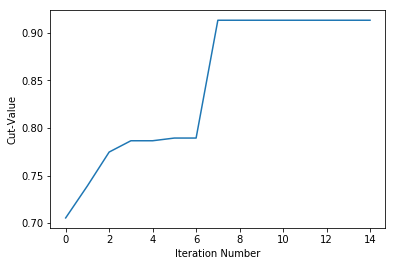

In [671]:
plot_convergence(convergence3)

### Test 4

In [673]:
convergence4 = qcpass(ibm_matrix, 10, 100, 2)

|   iter    |  target   |   beta    |   gamma   |
-------------------------------------------------
|  1        |  0.81     |  0.3611   |  5.001    |
|  2        |  0.9897   |  0.08084  |  5.095    |
|  3        |  0.7656   |  1.327    |  1.951    |
|  4        |  0.7216   |  2.066    |  0.4962   |
|  5        |  0.6884   |  1.445    |  5.688    |
|  6        |  0.9414   |  0.0      |  0.0      |
|  7        |  0.8499   |  0.0      |  6.283    |
|  8        |  0.8262   |  3.142    |  6.283    |
|  9        |  0.7951   |  3.142    |  3.279    |
|  10       |  0.8613   |  0.0      |  2.709    |
|  11       |  0.6941   |  3.142    |  1.467    |
|  12       |  0.7226   |  0.0      |  1.219    |
|  13       |  0.9551   |  3.142    |  0.0      |
|  14       |  0.7707   |  3.142    |  4.908    |
|  15       |  0.8636   |  0.0      |  4.029    |


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


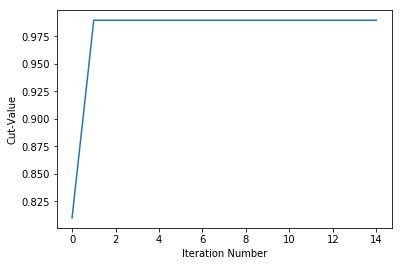

In [674]:
plot_convergence(convergence4)

### Test 5


In [ ]:
qcmultiple_pass(ibm_matrix, 5, n_iters=10, verbose = 2, shots = 30)

Starting 1th test
|   iter    |  target   |   beta    |   gamma   |
-------------------------------------------------
|  1        |  0.6509   |  1.146    |  5.954    |
|  2        |  0.8252   |  1.264    |  1.45     |
|  3        |  0.6559   |  2.692    |  2.408    |
|  4        |  0.7305   |  1.174    |  0.07727  |
|  5        |  0.7299   |  2.956    |  3.875    |
|  6        |  0.7398   |  0.0      |  3.168    |
|  7        |  0.7831   |  3.142    |  6.283    |
|  8        |  0.7165   |  0.0      |  0.5621   |
|  9        |  0.6491   |  1.396    |  3.445    |
|  10       |  0.6066   |  3.142    |  0.0      |
|  11       |  0.6116   |  0.0      |  6.283    |
|  12       |  0.6801   |  3.142    |  5.238    |
|  13       |  0.5763   |  0.0      |  1.907    |
|  14       |  0.665    |  0.0      |  4.686    |
